### Importing libraries

In [44]:
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot

### Load the dictionary containing the dataset

In [48]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Data Exploration


In [38]:
print  'Number of data points (persons) in the data set:', len(data_dict)

#Number of features for each person
num_features=0
for person in data_dict:
    num_features = len(data_dict[person])
    break
print 'Number of features for each person: ', num_features

#Number of POIs (persons of interest)
num_poi=0
for person in data_dict:
    if data_dict[person]["poi"]==1:
        num_poi+=1
        
print 'Number of POIs (persons of interest):', num_poi


Number of data points (persons) in the data set: 146
Number of features for each person:  21
Number of POIs (persons of interest): 18


In [40]:
### Getting the list of all the features in the dataset
n=0
features=[]
for key, value in data_dict.iteritems():
    if n==0:
        features =  value.keys()
    n+=1
    
###Count how many NaN each feature has and output feature name + count
def countNaN(feature_name):
    count=0
    for person in data_dict:
        if data_dict[person][feature_name] == 'NaN':
            count += 1
    print 'Number of NaNs for ', feature_name, ': ', count
    
for f in features:
    countNaN(f)

Number of NaNs for  salary :  51
Number of NaNs for  to_messages :  60
Number of NaNs for  deferral_payments :  107
Number of NaNs for  total_payments :  21
Number of NaNs for  exercised_stock_options :  44
Number of NaNs for  bonus :  64
Number of NaNs for  restricted_stock :  36
Number of NaNs for  shared_receipt_with_poi :  60
Number of NaNs for  restricted_stock_deferred :  128
Number of NaNs for  total_stock_value :  20
Number of NaNs for  expenses :  51
Number of NaNs for  loan_advances :  142
Number of NaNs for  from_messages :  60
Number of NaNs for  other :  53
Number of NaNs for  from_this_person_to_poi :  60
Number of NaNs for  poi :  0
Number of NaNs for  director_fees :  129
Number of NaNs for  deferred_income :  97
Number of NaNs for  long_term_incentive :  80
Number of NaNs for  email_address :  35
Number of NaNs for  from_poi_to_this_person :  60


From above we see that there are several features with many missing values: `deferral_payments, restricted_stock_deferred, loan_advances, loan_advances , director_fees ,deferred_income`. All of these fetures have around 100 and above missing values. Mentioned features may not be really good to use in the algorithm.

Also, `email_address` should not be used as a feature because email is unique for each person and can not be used to make distinction between POI or not POI. 

Let's see if there are any outliers in the finacial data. First, I want to plot salary and bonus.

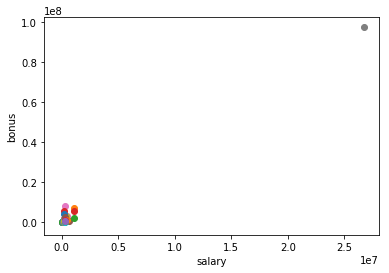

In [50]:
features = ['salary', 'bonus']

data = featureFormat(data_dict, features)

for point in data:
    salary = point[0]
    bonus = point[1]
    matplotlib.pyplot.scatter( salary, bonus )

matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("bonus")
matplotlib.pyplot.show()

From the graph above we see that there is a very extreme outlier. Now, I will investigate who the oultier is and remove him fprm the dataset

In [57]:
for person in data_dict:
    if data_dict[person]['salary']>2500000 and data_dict[person]['salary']!='NaN':
        print person

TOTAL


It appears that the data set has data point for total values. This data point should be removed.

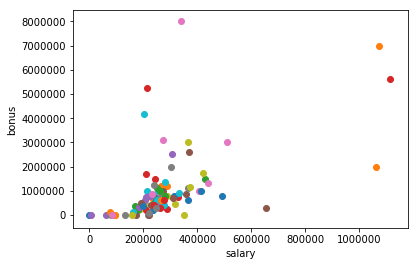

In [58]:
#Remove 'Total' value
data_dict.pop( "TOTAL", 0 ) 
data = featureFormat(data_dict, features)

for point in data:
    salary = point[0]
    bonus = point[1]
    matplotlib.pyplot.scatter( salary, bonus )

matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("bonus")
matplotlib.pyplot.show()

Now, the plot looks much better. However, there are still some oultiers. Let's investigate further.


In [62]:
for key, value in data_dict.iteritems():
    name = key
    salary = value["salary"]
    bonus = value["bonus"]
    poi = value['poi']
    if (salary!= 'NaN' and bonus!='NaN') and (int(salary)>= 1000000 and int(bonus)>=5000000):
        print name, ' - POI? -', poi

LAY KENNETH L  - POI? - True
SKILLING JEFFREY K  - POI? - True


Even though LAY KENNETH L and SKILLING JEFFREY K are outliers we can not remove them form the dataset since they are known POIs.

### Feature Selection

Out of all the features I will start with using `salary, bonus, total_stock_value, exercised_stock_options, from_this_person_to_poi, from_poi_to_this_person`. These are the fetures that I feel have the highest impact on the probability of being a POI.
Instead of using `from_this_person_to_poi` and `from_poi_to_this_person` directly I want to create 2 new features:
proportion of `from_this_person_to_poi` and `from_poi_to_this_person` in total emails. Absolute value of emails to/from POI does not make much sence by itself. If one person has sent 10 emails to POI but his total emails sent is 20 the proprotion is 0.5. While another person have also sent 10 emails but the total number sent is 100 making the prorption 0.1. The first person is  communicating more often with POI even though their total count of emails to POI is the same.

In [80]:
for person in data_dict:
    if data_dict[person]['from_this_person_to_poi']!='NaN':
        data_dict[person]['from_this_person_to_poi_proportion'] \
        = int(data_dict[person]['from_this_person_to_poi'])/float(data_dict[person]['from_messages'])
    else:
        data_dict[person]['from_this_person_to_poi_proportion']='NaN'
        
        
    if data_dict[person]['from_poi_to_this_person']!='NaN':
        data_dict[person]['from_poi_to_this_person_proportion'] \
        = int(data_dict[person]['from_poi_to_this_person'])/float(data_dict[person]['to_messages'])
    else:
        data_dict[person]['from_poi_to_this_person_proportion']='NaN'
        


In [93]:
features_list = ['poi','salary', 'bonus', 'total_stock_value', 'exercised_stock_options', 'from_this_person_to_poi_proportion',
                 'from_poi_to_this_person_proportion']

my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Trying a varity of classifiers

In [92]:
##Splitting the data into train and test
features_train, features_test, labels_train, labels_test=train_test_split(features, labels, test_size=.3,random_state=42)

clf=tree.DecisionTreeClassifier()
clf.fit(features_train, labels_train)

pred=clf.predict(features_test)
print 'Accuracy Score:' , accuracy_score(pred,labels_test)

Accuracy Score: 0.825


#### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
